In [65]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from tqdm import tqdm
from PIL import Image
from IPython.display import Image as ImageDisplay

In [ ]:
! mkdir datasets

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, train=False, download=True)

# create train and test dataloaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
len(train_loader), len(test_loader)

(469, 79)

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: >]


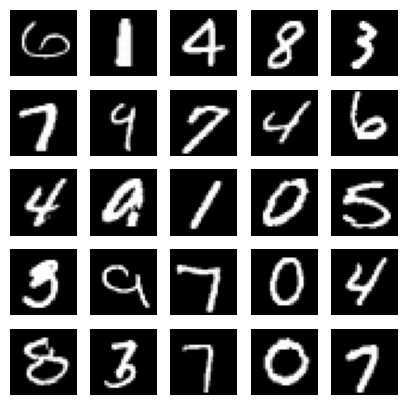

In [ ]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig, axs = plt.subplots(5, 5, figsize=(5, 5))

print(axs.flatten())

for ax, im in zip(axs.flatten(), sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim=784, hidden_dims=(64, 32), latent_dim=2):
        super(VAE, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_dim, out_features=hidden_dims[0], bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1], bias=True),
            torch.nn.ReLU(),
        )

        self.latent_mean = torch.nn.Linear(hidden_dims[-1], latent_dim)
        self.latent_var = torch.nn.Linear(hidden_dims[-1], latent_dim)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=latent_dim, out_features=hidden_dims[-1], bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dims[-1], out_features=hidden_dims[-2], bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_dims[-2], out_features=input_dim, bias=True),
            torch.nn.Sigmoid()
        )

    def reparametrization(self, mu, var):
        epsilon = torch.randn_like(var, device=var.device)
        return mu + var * epsilon

    def encode(self, x):
        x = self.encoder(x)
        mean, var = self.latent_mean(x), torch.exp(self.latent_var(x))
        return self.reparametrization(mean, var), mean, var

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z, mean, var = self.encode(x)
        out = self.decode(z)
        return out, mean, var

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (latent_mean): Linear(in_features=32, out_features=2, bias=True)
  (latent_var): Linear(in_features=32, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
def vae_loss(x, x_hat, mean, var):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = (var**2 + mean**2 - torch.log(var) - 1/2).sum()

    return reproduction_loss + KLD

In [ ]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [ ]:
config = {
    'epochs': 50,
    'batch_size': batch_size,
    'input_shape': 784,
}

In [ ]:
def training(model, optimizer, train_dataloader, test_dataloader, config):
    history = {
        'train_losses': [],
        'val_losses': []
    }
    for epoch in range(config['epochs']):
        print('\tEpoch:', epoch + 1)
        train_loss = 0.0
        val_loss = 0.0

        # train
        model.train()
        for step, (x, _) in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
            b = x.shape[0]
            x = x.view(b, config['input_shape']).to(device)

            x_hat, mean, var = model(x)

            loss = vae_loss(x, x_hat, mean, var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        print('--> Train Loss:', train_loss / len(train_dataloader) / config['batch_size'])

        history['train_losses'].append(train_loss / len(train_dataloader) / config['batch_size'])

        # test
        model.eval()
        for step, (x, _) in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
            b = x.shape[0]
            x = x.view(b, config['input_shape']).to(device)

            x_hat, mean, var = model(x)

            loss = vae_loss(x, x_hat, mean, var)

            val_loss += loss.item()
        print('--> Validation Loss:', val_loss / len(test_dataloader) / config['batch_size'])

        history['val_losses'].append(val_loss / len(test_dataloader) / config['batch_size'])

    return history

In [ ]:
history = training(model, optimizer, train_loader, test_loader, config=config)
history

	Epoch: 1


100%|██████████| 469/469 [00:08<00:00, 55.49it/s]


--> Train Loss: 224.75125096042527


100%|██████████| 79/79 [00:01<00:00, 69.51it/s]


--> Validation Loss: 189.78091565868522
	Epoch: 2


100%|██████████| 469/469 [00:08<00:00, 54.09it/s]


--> Train Loss: 184.0474104240759


100%|██████████| 79/79 [00:01<00:00, 71.17it/s]


--> Validation Loss: 175.6439965646478
	Epoch: 3


100%|██████████| 469/469 [00:08<00:00, 54.47it/s]


--> Train Loss: 174.99323511835354


100%|██████████| 79/79 [00:01<00:00, 65.93it/s]


--> Validation Loss: 170.3722361794001
	Epoch: 4


100%|██████████| 469/469 [00:07<00:00, 59.08it/s]


--> Train Loss: 170.58152744968308


100%|██████████| 79/79 [00:01<00:00, 54.21it/s]


--> Validation Loss: 166.797950527336
	Epoch: 5


100%|██████████| 469/469 [00:08<00:00, 56.01it/s]


--> Train Loss: 167.42908729927373


100%|██████████| 79/79 [00:01<00:00, 62.87it/s]


--> Validation Loss: 163.99594560454165
	Epoch: 6


100%|██████████| 469/469 [00:09<00:00, 50.51it/s]


--> Train Loss: 164.819427473967


100%|██████████| 79/79 [00:01<00:00, 69.68it/s]


--> Validation Loss: 161.6083776256706
	Epoch: 7


100%|██████████| 469/469 [00:08<00:00, 53.21it/s]


--> Train Loss: 162.69401005336218


100%|██████████| 79/79 [00:01<00:00, 70.91it/s]


--> Validation Loss: 160.11661505397362
	Epoch: 8


100%|██████████| 469/469 [00:08<00:00, 57.56it/s]


--> Train Loss: 161.16760257159723


100%|██████████| 79/79 [00:01<00:00, 48.60it/s]


--> Validation Loss: 158.54124648661553
	Epoch: 9


100%|██████████| 469/469 [00:08<00:00, 55.48it/s]


--> Train Loss: 159.8140940879708


100%|██████████| 79/79 [00:01<00:00, 69.33it/s]


--> Validation Loss: 157.15823076948334
	Epoch: 10


100%|██████████| 469/469 [00:08<00:00, 54.31it/s]


--> Train Loss: 158.51417113672187


100%|██████████| 79/79 [00:01<00:00, 69.19it/s]


--> Validation Loss: 156.40096838263017
	Epoch: 11


100%|██████████| 469/469 [00:08<00:00, 54.45it/s]


--> Train Loss: 157.58651551203943


100%|██████████| 79/79 [00:01<00:00, 69.02it/s]


--> Validation Loss: 155.33212886279142
	Epoch: 12


100%|██████████| 469/469 [00:08<00:00, 56.35it/s]


--> Train Loss: 156.75740396137684


100%|██████████| 79/79 [00:01<00:00, 50.65it/s]


--> Validation Loss: 154.57333096371423
	Epoch: 13


100%|██████████| 469/469 [00:08<00:00, 54.33it/s]


--> Train Loss: 156.14137281080298


100%|██████████| 79/79 [00:01<00:00, 70.07it/s]


--> Validation Loss: 154.07614437537856
	Epoch: 14


100%|██████████| 469/469 [00:08<00:00, 54.29it/s]


--> Train Loss: 155.40474442276619


100%|██████████| 79/79 [00:01<00:00, 71.10it/s]


--> Validation Loss: 153.43172288242775
	Epoch: 15


100%|██████████| 469/469 [00:08<00:00, 53.72it/s]


--> Train Loss: 154.6942575938666


100%|██████████| 79/79 [00:01<00:00, 72.58it/s]


--> Validation Loss: 153.20295964011663
	Epoch: 16


100%|██████████| 469/469 [00:07<00:00, 59.06it/s]


--> Train Loss: 154.20752416744924


100%|██████████| 79/79 [00:01<00:00, 55.09it/s]


--> Validation Loss: 152.30874653103984
	Epoch: 17


100%|██████████| 469/469 [00:08<00:00, 54.83it/s]


--> Train Loss: 153.6420607414327


100%|██████████| 79/79 [00:01<00:00, 69.14it/s]


--> Validation Loss: 151.97316128694558
	Epoch: 18


100%|██████████| 469/469 [00:08<00:00, 54.55it/s]


--> Train Loss: 153.20930952710637


100%|██████████| 79/79 [00:01<00:00, 71.55it/s]


--> Validation Loss: 151.55182143102718
	Epoch: 19


100%|██████████| 469/469 [00:08<00:00, 53.34it/s]


--> Train Loss: 152.99733830108318


100%|██████████| 79/79 [00:01<00:00, 68.83it/s]


--> Validation Loss: 151.6114987240562
	Epoch: 20


100%|██████████| 469/469 [00:07<00:00, 59.41it/s]


--> Train Loss: 152.48853318269317


100%|██████████| 79/79 [00:01<00:00, 57.56it/s]


--> Validation Loss: 151.02567078795613
	Epoch: 21


100%|██████████| 469/469 [00:08<00:00, 55.03it/s]


--> Train Loss: 152.15400207779808


100%|██████████| 79/79 [00:01<00:00, 69.52it/s]


--> Validation Loss: 150.551015564158
	Epoch: 22


100%|██████████| 469/469 [00:08<00:00, 53.99it/s]


--> Train Loss: 152.30633512387143


100%|██████████| 79/79 [00:01<00:00, 69.30it/s]


--> Validation Loss: 150.681670104401
	Epoch: 23


100%|██████████| 469/469 [00:08<00:00, 53.70it/s]


--> Train Loss: 151.66796354444296


100%|██████████| 79/79 [00:01<00:00, 71.88it/s]


--> Validation Loss: 150.2435169702844
	Epoch: 24


100%|██████████| 469/469 [00:07<00:00, 60.20it/s]


--> Train Loss: 151.4479496189272


100%|██████████| 79/79 [00:01<00:00, 56.88it/s]


--> Validation Loss: 149.87609027910835
	Epoch: 25


100%|██████████| 469/469 [00:08<00:00, 55.40it/s]


--> Train Loss: 150.9248912461531


100%|██████████| 79/79 [00:01<00:00, 67.96it/s]


--> Validation Loss: 149.67498364026034
	Epoch: 26


100%|██████████| 469/469 [00:08<00:00, 54.12it/s]


--> Train Loss: 150.61364889246568


100%|██████████| 79/79 [00:01<00:00, 69.36it/s]


--> Validation Loss: 149.2111634845975
	Epoch: 27


100%|██████████| 469/469 [00:08<00:00, 54.14it/s]


--> Train Loss: 150.35940169474716


100%|██████████| 79/79 [00:01<00:00, 70.70it/s]


--> Validation Loss: 149.17161011997658
	Epoch: 28


100%|██████████| 469/469 [00:08<00:00, 57.67it/s]


--> Train Loss: 150.15131059333459


100%|██████████| 79/79 [00:01<00:00, 50.95it/s]


--> Validation Loss: 148.98471694656564
	Epoch: 29


100%|██████████| 469/469 [00:08<00:00, 56.22it/s]


--> Train Loss: 149.9049687497397


100%|██████████| 79/79 [00:01<00:00, 69.65it/s]


--> Validation Loss: 148.71306701853305
	Epoch: 30


100%|██████████| 469/469 [00:08<00:00, 54.22it/s]


--> Train Loss: 149.62643666867254


100%|██████████| 79/79 [00:01<00:00, 68.50it/s]


--> Validation Loss: 148.35581586330753
	Epoch: 31


100%|██████████| 469/469 [00:08<00:00, 55.28it/s]


--> Train Loss: 149.5216239164633


100%|██████████| 79/79 [00:01<00:00, 68.64it/s]


--> Validation Loss: 148.02165473261965
	Epoch: 32


100%|██████████| 469/469 [00:07<00:00, 60.47it/s]


--> Train Loss: 149.16036987304688


100%|██████████| 79/79 [00:01<00:00, 55.84it/s]


--> Validation Loss: 147.92457817174213
	Epoch: 33


100%|██████████| 469/469 [00:08<00:00, 56.24it/s]


--> Train Loss: 149.33590694988715


100%|██████████| 79/79 [00:01<00:00, 69.77it/s]


--> Validation Loss: 147.82468312903296
	Epoch: 34


100%|██████████| 469/469 [00:08<00:00, 54.53it/s]


--> Train Loss: 149.08163256940048


100%|██████████| 79/79 [00:01<00:00, 68.37it/s]


--> Validation Loss: 147.80900747564775
	Epoch: 35


100%|██████████| 469/469 [00:08<00:00, 53.97it/s]


--> Train Loss: 148.81946885814546


100%|██████████| 79/79 [00:01<00:00, 71.22it/s]


--> Validation Loss: 147.55228766912145
	Epoch: 36


100%|██████████| 469/469 [00:07<00:00, 60.04it/s]


--> Train Loss: 148.61863932985742


100%|██████████| 79/79 [00:01<00:00, 59.04it/s]


--> Validation Loss: 147.61025168020515
	Epoch: 37


100%|██████████| 469/469 [00:08<00:00, 55.25it/s]


--> Train Loss: 148.50614374482046


100%|██████████| 79/79 [00:01<00:00, 71.47it/s]


--> Validation Loss: 147.5711979926387
	Epoch: 38


100%|██████████| 469/469 [00:08<00:00, 54.79it/s]


--> Train Loss: 148.76423339193056


100%|██████████| 79/79 [00:01<00:00, 69.42it/s]


--> Validation Loss: 147.36967424803143
	Epoch: 39


100%|██████████| 469/469 [00:08<00:00, 54.21it/s]


--> Train Loss: 148.46212932855082


100%|██████████| 79/79 [00:01<00:00, 68.94it/s]


--> Validation Loss: 147.109213865256
	Epoch: 40


100%|██████████| 469/469 [00:07<00:00, 60.44it/s]


--> Train Loss: 148.11785338834912


100%|██████████| 79/79 [00:01<00:00, 64.37it/s]


--> Validation Loss: 147.8715431841114
	Epoch: 41


100%|██████████| 469/469 [00:08<00:00, 55.27it/s]


--> Train Loss: 148.2394725579951


100%|██████████| 79/79 [00:01<00:00, 69.09it/s]


--> Validation Loss: 147.2909133766271
	Epoch: 42


100%|██████████| 469/469 [00:08<00:00, 54.55it/s]


--> Train Loss: 147.98124465454362


100%|██████████| 79/79 [00:01<00:00, 69.89it/s]


--> Validation Loss: 147.26760753197007
	Epoch: 43


100%|██████████| 469/469 [00:08<00:00, 56.54it/s]


--> Train Loss: 148.13032460161872


100%|██████████| 79/79 [00:01<00:00, 60.93it/s]


--> Validation Loss: 146.9777704069886
	Epoch: 44


100%|██████████| 469/469 [00:07<00:00, 59.39it/s]


--> Train Loss: 147.82981460994242


100%|██████████| 79/79 [00:01<00:00, 64.29it/s]


--> Validation Loss: 147.19203202935714
	Epoch: 45


100%|██████████| 469/469 [00:08<00:00, 54.73it/s]


--> Train Loss: 147.9559959623097


100%|██████████| 79/79 [00:01<00:00, 69.97it/s]


--> Validation Loss: 146.88079225564306
	Epoch: 46


100%|██████████| 469/469 [00:08<00:00, 54.18it/s]


--> Train Loss: 147.76312825217175


100%|██████████| 79/79 [00:01<00:00, 70.59it/s]


--> Validation Loss: 147.02035785626762
	Epoch: 47


100%|██████████| 469/469 [00:09<00:00, 47.90it/s]


--> Train Loss: 147.64804410629435


100%|██████████| 79/79 [00:01<00:00, 67.80it/s]


--> Validation Loss: 146.80417401277566
	Epoch: 48


100%|██████████| 469/469 [00:08<00:00, 58.39it/s]


--> Train Loss: 147.3584835158228


100%|██████████| 79/79 [00:01<00:00, 50.10it/s]


--> Validation Loss: 146.19919781745236
	Epoch: 49


100%|██████████| 469/469 [00:08<00:00, 57.34it/s]


--> Train Loss: 147.38689778862732


100%|██████████| 79/79 [00:01<00:00, 69.68it/s]


--> Validation Loss: 146.32703242724455
	Epoch: 50


100%|██████████| 469/469 [00:08<00:00, 53.19it/s]


--> Train Loss: 147.16063491723685


100%|██████████| 79/79 [00:01<00:00, 68.16it/s]

--> Validation Loss: 146.24080981483942


{'train_losses': [105408.33670043945,
  86318.2354888916,
  82071.82727050781,
  80002.73637390137,
  78524.24194335938,
  77300.31148529053,
  76303.49071502686,
  75587.6056060791,
  74952.8101272583,
  74343.14626312256,
  73908.07577514648,
  73519.22245788574,
  73230.3038482666,
  72884.82513427734,
  72551.60681152344,
  72323.32883453369,
  72058.12648773193,
  71855.16616821289,
  71755.75166320801,
  71517.1220626831,
  71360.2269744873,
  71431.6711730957,
  71132.27490234375,
  71029.08837127686,
  70783.7739944458,
  70637.8013305664,
  70518.55939483643,
  70420.96466827393,
  70305.43034362793,
  70174.79879760742,
  70125.64161682129,
  69956.21347045898,
  70038.54035949707,
  69919.28567504883,
  69796.33089447021,
  69702.14184570312,
  69649.3814163208,
  69770.42546081543,
  69628.73865509033,
  69467.27323913574,
  69524.3126296997,
  69403.20374298096,
  69473.12223815918,
  69332.18305206299,
  69391.36210632324,
  69300.90715026855,
  69246.93268585205,
  69111

In [ ]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    fig.show()

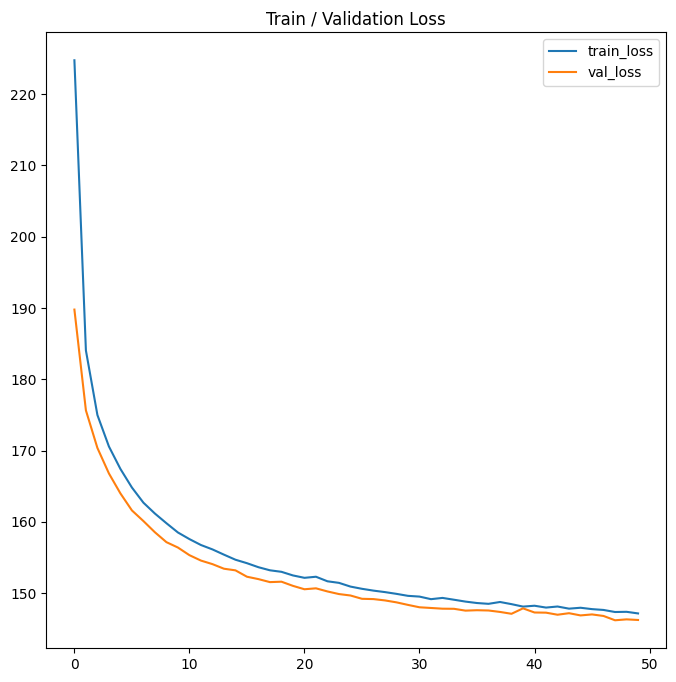

In [ ]:
plot_results(history)

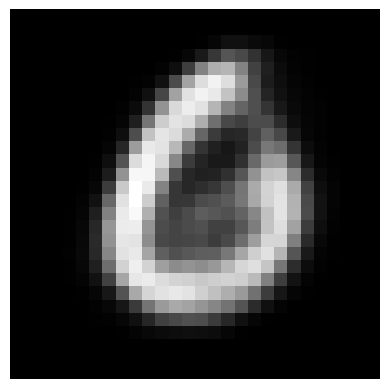

In [ ]:
def generate_digit(model, mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(model, 0.0, 1.0)

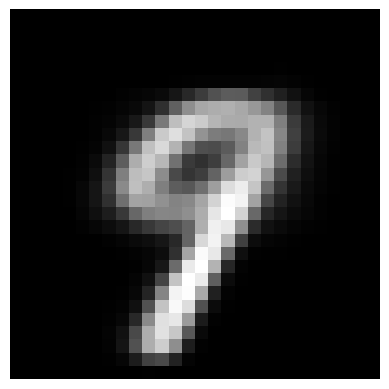

In [ ]:
generate_digit(model, 1.0, 0.0)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

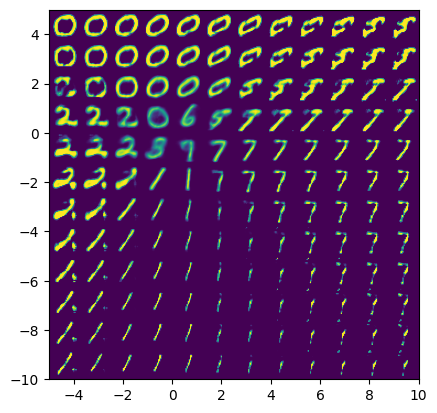

In [ ]:
plot_reconstructed(model)

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        b = x.shape[0]
        x = x.view(b, config['input_shape']).to(device)
        y = y.view(b)

        z, _, _ = autoencoder.encode(x)
        z = z.cpu().detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

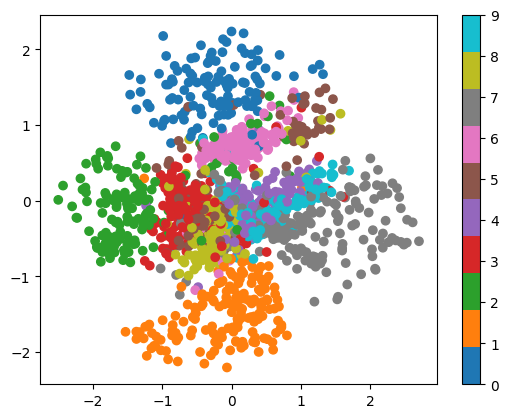

In [ ]:
plot_latent(model, train_loader, num_batches=10)

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1, _, _ = autoencoder.encode(x_1)
    z_2, _, _ = autoencoder.encode(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [67]:
x, y = iter(train_loader).__next__() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

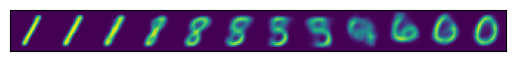

In [68]:
interpolate(model, x_1.view(1, 784), x_2.view(1, 784))

In [69]:
def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1, _, _ = autoencoder.encode(x_1)
    z_2, _, _ = autoencoder.encode(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decode(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [70]:
interpolate_gif(model, "vae", x_1.view(1, 784), x_2.view(1, 784))

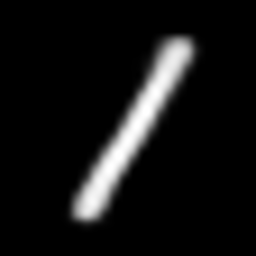

In [71]:
ImageDisplay(open('vae.gif', 'rb').read())